In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, FashionMNIST
from torch.utils.data import DataLoader, Dataset
from sklearn.cluster import KMeans
import torch.nn as nn
import torch.nn.functional as F
import copy
from scipy.stats import ortho_group
from google.colab import drive
drive.mount('/content/drive')

device = torch.device('cpu')
#device = torch.device('cuda')
#torch.cuda.get_device_name(device)
torch.manual_seed(0)
np.random.seed(0)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0],[1])
])

In [3]:
path0='./'
path='./'

In [4]:
dataset_MNIST = MNIST(root=path0, download=True, transform=transform, train=True)
dataset_FMNIST = FashionMNIST(root=path0, download=True, transform=transform, train=True)
dataset_MNIST_test = MNIST(root=path0, download=True, transform=transform, train=False)
dataset_FMNIST_test = FashionMNIST(root=path0, download=True, transform=transform, train=False)

# Train Autoencoders

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU()
        )

        self.flatten = nn.Flatten(start_dim=1)

        self.e = nn.Sequential(
            nn.Linear(3*3*32, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(), 
            nn.Linear(64, 32),
            nn.ReLU(), 
            nn.Linear(32, 16)
        )

        self.d = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(), 
            nn.Linear(32, 64),
            nn.ReLU(), 
            nn.Linear(64, 128),
            nn.ReLU(), 
            nn.Linear(128, 3*3*32)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        self.dcnn = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def encode(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.e(x)

        return x

    def decode(self, x):
        x = self.d(x)
        x = self.unflatten(x)
        x = self.dcnn(x)

        return x
        
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)

        return x

In [6]:
class TwoModal(Dataset):
    def __init__(self, data1, data2, idx=None):
        self.d1 = torch.empty((0, 28, 28), device=device)
        self.d2 = torch.empty((0, 28, 28), device=device)
        self.t1 = torch.empty((0, ), device=device)
        if idx is None:
            idx = np.arange(np.min((len(data1), len(data2))))

        for i in range(10):
            idx1 = (data1.targets[idx] == i)
            idx2 = (data2.targets[idx] == i)
            label_count = np.min([idx1.sum().numpy(), idx2.sum().numpy()])
            data1_c = data1.data[idx][idx1][:label_count]
            data2_c = data2.data[idx][idx2][:label_count]
            self.t1 = torch.cat((self.t1, torch.full((label_count, ), i)))
            self.d1 = torch.cat((self.d1, data1_c))
            self.d2 = torch.cat((self.d2, data2_c))
        self.t2 = torch.clone(self.t1)

    def __len__(self):
        return len(self.t1)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return self.d1[idx], self.d2[idx], self.t1[idx], self.t2[idx]

In [7]:
loss_fn = nn.MSELoss()
num_epochs = 20
learning_rate = 2e-3
batch_size = 64

In [8]:
TM_ae = TwoModal(dataset_MNIST, dataset_FMNIST)
TM_test = TwoModal(dataset_MNIST_test, dataset_FMNIST_test)

dataloader_u = DataLoader(TM_ae, batch_size=batch_size, shuffle=True)
AE_MNIST = Autoencoder()
optimizer = torch.optim.AdamW(AE_MNIST.parameters(), lr=learning_rate)

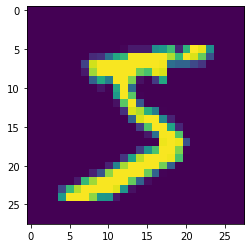

In [9]:
img = dataset_MNIST.data[0]
plt.imshow(img)

[Epoch 0] loss: 2.174e+03


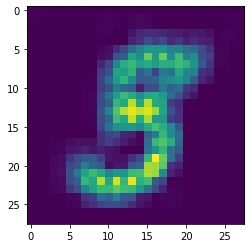

[Epoch 1] loss: 1.773e+03


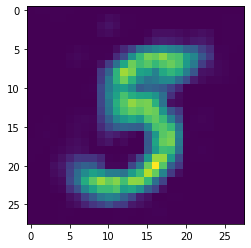

[Epoch 2] loss: 1.520e+03


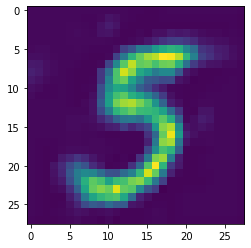

[Epoch 3] loss: 1.362e+03


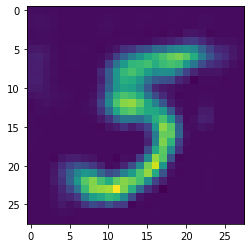

[Epoch 4] loss: 1.352e+03


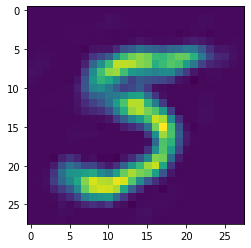

[Epoch 5] loss: 1.156e+03


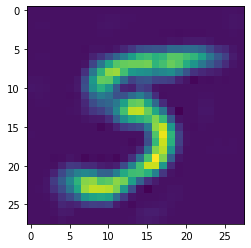

[Epoch 6] loss: 1.144e+03


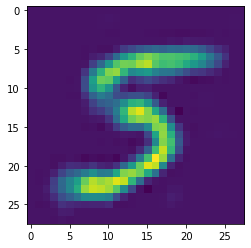

[Epoch 7] loss: 1.077e+03


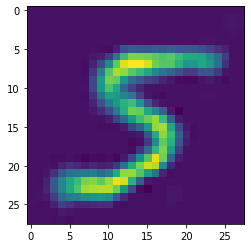

[Epoch 8] loss: 1.123e+03


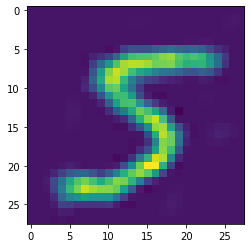

[Epoch 9] loss: 9.909e+02


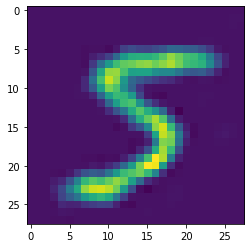

[Epoch 10] loss: 9.081e+02


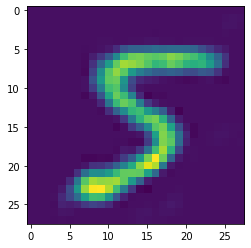

[Epoch 11] loss: 9.531e+02


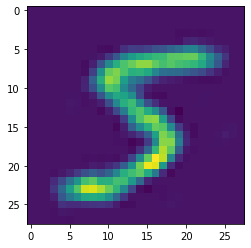

[Epoch 12] loss: 8.342e+02


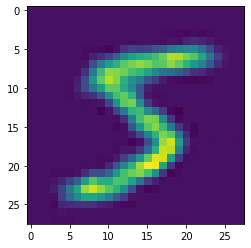

[Epoch 13] loss: 8.449e+02


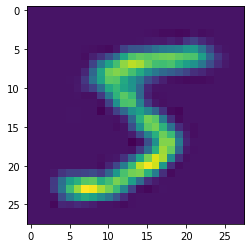

[Epoch 14] loss: 9.287e+02


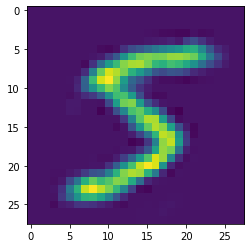

[Epoch 15] loss: 7.972e+02


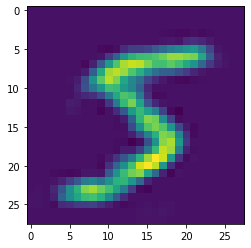

[Epoch 16] loss: 7.813e+02


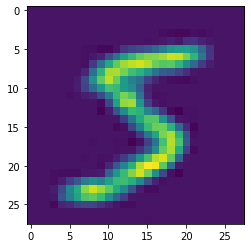

[Epoch 17] loss: 7.731e+02


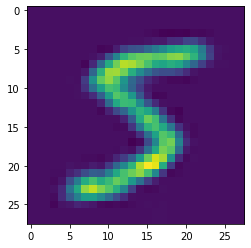

[Epoch 18] loss: 7.640e+02


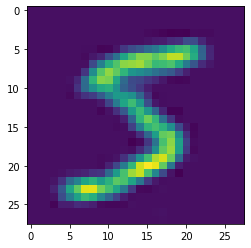

[Epoch 19] loss: 7.900e+02


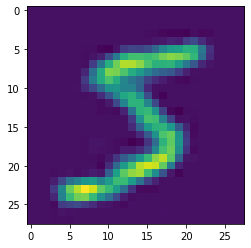

In [10]:
for epoch in range(num_epochs):
    for data in dataloader_u:
        mnist, _, _, _ = data

        optimizer.zero_grad()
        mnist_restored = AE_MNIST(mnist.reshape(-1, 1, 28, 28)).reshape(-1, 28, 28)
        loss = loss_fn(mnist_restored, mnist)
        loss.backward()

        optimizer.step()
        
    print(f"[Epoch {epoch}] loss: {loss:.3e}")
    plt.imshow(AE_MNIST(img.reshape(1, 1, 28, 28).float()).detach().numpy().reshape(28, 28))
    plt.show()

torch.save(AE_MNIST, path+'AE_MNIST')

In [11]:
AE_FMNIST = Autoencoder()
optimizer = torch.optim.AdamW(AE_FMNIST.parameters(), lr=learning_rate)

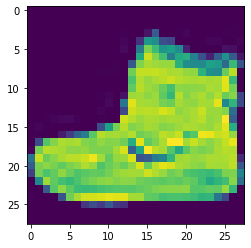

In [12]:
img = dataset_FMNIST.data[0]
plt.imshow(img)

[Epoch 0] loss: 2.345e+03


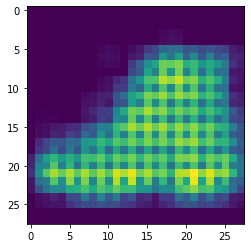

[Epoch 1] loss: 1.560e+03


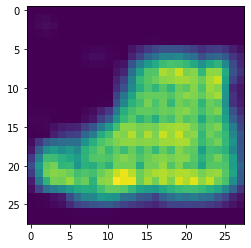

[Epoch 2] loss: 1.320e+03


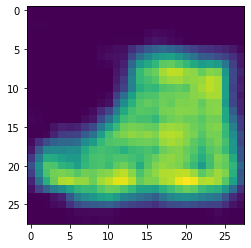

[Epoch 3] loss: 1.402e+03


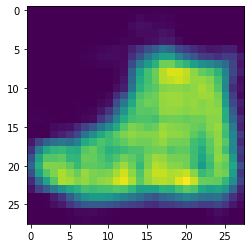

[Epoch 4] loss: 1.227e+03


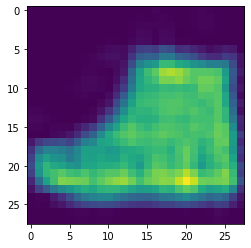

[Epoch 5] loss: 1.232e+03


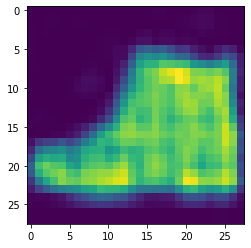

[Epoch 6] loss: 9.524e+02


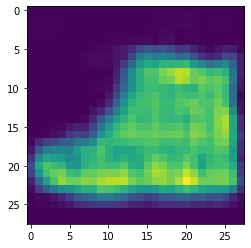

[Epoch 7] loss: 1.101e+03


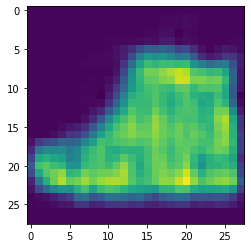

[Epoch 8] loss: 1.220e+03


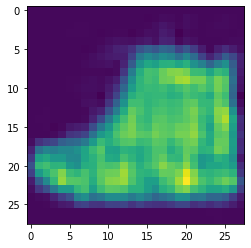

[Epoch 9] loss: 9.052e+02


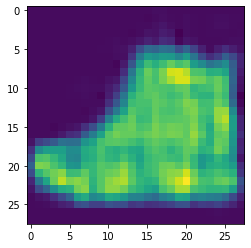

[Epoch 10] loss: 9.744e+02


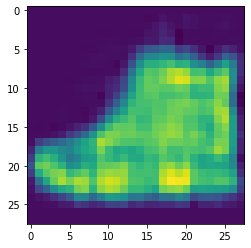

[Epoch 11] loss: 1.005e+03


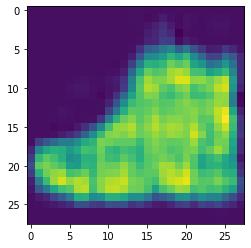

[Epoch 12] loss: 9.239e+02


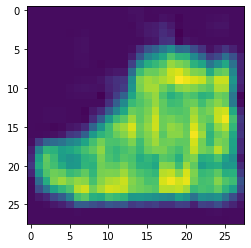

[Epoch 13] loss: 9.356e+02


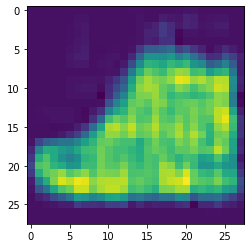

[Epoch 14] loss: 9.791e+02


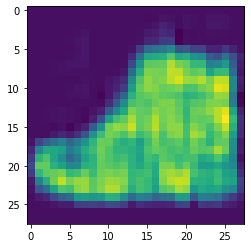

[Epoch 15] loss: 8.865e+02


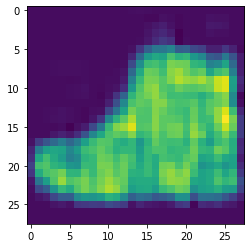

[Epoch 16] loss: 8.449e+02


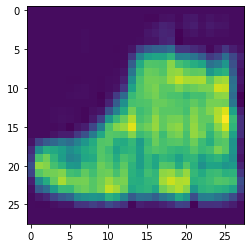

[Epoch 17] loss: 9.476e+02


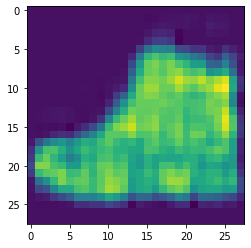

[Epoch 18] loss: 9.297e+02


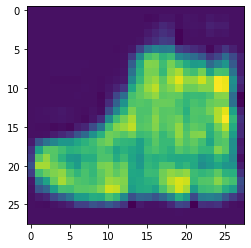

[Epoch 19] loss: 9.276e+02


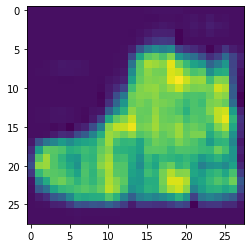

In [13]:
for epoch in range(num_epochs):
    for data in dataloader_u:
        _, fmnist, _, _ = data

        fmnist_restored = AE_FMNIST(fmnist.reshape(-1, 1, 28, 28)).reshape(-1, 28, 28)

        loss = loss_fn(fmnist_restored, fmnist)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"[Epoch {epoch}] loss: {loss:.3e}")
    plt.imshow(AE_FMNIST(img.reshape(1, 1, 28, 28).float()).detach().numpy().reshape(28, 28))
    plt.show()

torch.save(AE_FMNIST, path+'AE_FMNIST')